#Importa as bibliotecas necessarias

In [6]:
import numpy as np
from random import random
import os
import matplotlib.pyplot as plt
import matplotlib
import glob
import plotly.express as px
import plotly

import pandas as pd
pd.options.plotting.backend = 'plotly'

from tqdm.auto import tqdm
import time
from PIL import Image
from PIL.TiffTags import TAGS_V2

import skimage
from skimage import exposure, data, img_as_float
from skimage.filters import try_all_threshold, threshold_otsu, unsharp_mask, gaussian
from skimage.restoration import denoise_bilateral
from skimage.segmentation import clear_border, expand_labels
from skimage.measure import label, regionprops, regionprops_table
from skimage.morphology import closing, square, binary_dilation, binary_erosion, remove_small_holes, remove_small_objects
from scipy import ndimage as ndi

# Para montar o GDrive descomente as linhas abaixo:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Verificar a versao da lib scikit-image

In [2]:
print(skimage.__version__)

0.23.2


###Se a versão for menor que 0.20, atualize executando a célula abaixo e REINICIE o notebook

In [4]:
!python -m pip install -U scikit-image

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 35.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.5/313.5 kB 30.5 MB/s eta 0:00:00
  Attempting uninstall: imageio
    Found existing installation: imageio 2.31.6
    Uninstalling imageio-2.31.6:
      Successfully uninstalled imageio-2.31.6
  Attempting uninstall: scikit-image
    Found existing installation: scikit-image 0.19.3
    Uninstalling scikit-image-0.19.3:
      Successfully uninstalled scikit-image-0.19.3


##Define a função de analise e quantificação

In [8]:
def rodar_analise(arquivo, k=0.,px=0.028, plot=False):
  #Abrir Imagem
  img_orig = Image.open(arquivo)
  # extrair dados do nome do arquivo
  plate = str.split(os.path.basename(arquivo)[:-4], "_")[0]
  well = str.split(os.path.basename(arquivo)[:-4], "_")[1]
  sample = str.split(os.path.basename(arquivo)[:-4], "_")[2]

  #converte para numpy
  img = np.array(img_orig)

  #calibracao da imagem
  pixel_size = px #em micrometros de acordo com aproximacao no imagej

  #equalizacao
  img_eq = exposure.equalize_adapthist(img)

  # denoise
  img_denoised = gaussian(img_eq, sigma=10)

  #unsharp
  img_eq_unsharp = unsharp_mask(img_denoised, radius=5, amount=1)

  # Otsu threshold
  thresh_otsu = threshold_otsu(img_eq_unsharp)
  print(" theshold:", thresh_otsu)
  img_thresh = (img_eq_unsharp > thresh_otsu +k) * 1

  #remove holes in nucleus
  img_remove_holes = ndi.binary_fill_holes(img_thresh)

  #remove objetos muito pequenos
  img_remove_small= remove_small_objects(img_remove_holes, 100)

  # remove objetos cortados na bordas
  img_clear = clear_border(img_remove_small)

  # separar cada objeto (labeling)
  label_image_nucleus = label(img_clear)

  ## criar banda perinuclear mantendo a mesma label
  dilate = binary_dilation(img_clear, footprint=square(10))
  erode = binary_erosion(img_clear, footprint=square(10))
  mask = np.logical_and(dilate, ~erode)
  label_image_nucleus_rim = mask * expand_labels(label_image_nucleus, distance=10)

  #quantificação
  df_nucleus = pd.DataFrame(regionprops_table(label_image_nucleus,
                                            intensity_image=img,
                                            spacing=(pixel_size, pixel_size),
                                            properties=("label",
                                                       "area",
                                                        "area_convex",
                                                        "axis_major_length",
                                                        "axis_minor_length",
                                                        "eccentricity",
                                                        "euler_number",
                                                        "image_intensity",
                                                        "intensity_max",
                                                        "intensity_mean",
                                                        "intensity_min",
                                                        "perimeter",
                                                        "solidity")))
  #renonear colunas no df_nucleus
  d_n = dict(zip(list(df_nucleus.columns)[1:], [i+"_nucleus" for i in list(df_nucleus.columns)[1:]]))
  df_nucleus = df_nucleus.rename(columns=d_n)

  df_nucleus_rim = pd.DataFrame(regionprops_table(label_image_nucleus_rim,
                                            intensity_image=img,
                                            spacing=(pixel_size, pixel_size),
                                            properties=("label",
                                                       "area",
                                                        "image_intensity",
                                                        "intensity_max",
                                                        "intensity_mean",
                                                        "intensity_min")))
  #renomear columnas no df_nucleus_rim
  d_r = dict(zip(list(df_nucleus_rim.columns)[1:], [i+"_rim" for i in list(df_nucleus_rim.columns)[1:]]))
  df_nucleus_rim = df_nucleus_rim.rename(columns=d_r)

  #juntar os DF com base nos labels das celulas
  df_final = pd.merge(df_nucleus, df_nucleus_rim, on="label")

  #inserir dados do experimento no df
  df_final["plate"] = plate
  df_final["well"] = well
  df_final["sample"] = sample

  if plot:
    colors = [(0,0,0)] + [(random(),random(),random()) for i in range(255)]
    new_map = matplotlib.colors.LinearSegmentedColormap.from_list('new_map', colors, N=256)

    fig, axes = plt.subplots(2, 5, sharex=True, sharey=True, figsize=(12,6))
    fig.suptitle(arquivo, fontsize=16)
    axes[1,3].set_axis_off()

    axes[0,0].imshow(img, interpolation = "none")
    axes[0,0].set_title('original')
    axes[0,1].imshow(img_eq, interpolation = "none")
    axes[0,1].set_title('equalizado')
    axes[0,2].imshow(img_denoised, interpolation = "none")
    axes[0,2].set_title('denoised')
    axes[0,3].imshow(img_eq_unsharp, interpolation = "none")
    axes[0,3].set_title('unsharp')
    axes[0,4].imshow(img_thresh, interpolation = "none")
    axes[0,4].set_title('thresholded')

    axes[1,0].imshow(img_remove_holes, interpolation = "none")
    axes[1,0].set_title('remove holes')
    axes[1,1].imshow(img_remove_small, interpolation = "none")
    axes[1,1].set_title('revome small obj')
    axes[1,2].imshow(img_clear, interpolation = "none")
    axes[1,2].set_title('clear border')
    axes[1,3].imshow(label_image_nucleus, cmap = new_map, interpolation = "none")
    axes[1,3].set_title('labels')
    #axes[1,4].imshow(np.ma.masked_where(label_image_nucleus < 0.05, label_image_nucleus), cmap = "Set1", interpolation="none")
    #axes[1,4].set_title('rim mask')
    axes[1,4].imshow(img, interpolation = "none")
    axes[1,4].imshow(np.ma.masked_where(label_image_nucleus_rim < 0.05, label_image_nucleus_rim), cmap = new_map, interpolation="none", alpha=0.8)
    axes[1,4].set_title('overlay')

    fig.tight_layout()
    plt.show()

  return df_final

###Lista arquivos de imagens na pasta

In [19]:
dir = "/content/drive/MyDrive/Colab Notebooks/CellAtlas_Subset/"
arquivos = glob.glob(dir + "*.tif")
arquivos

['/content/drive/MyDrive/Colab Notebooks/CellAtlas_Subset/1894_G3_5.tif',
 '/content/drive/MyDrive/Colab Notebooks/CellAtlas_Subset/1894_G3_4.tif',
 '/content/drive/MyDrive/Colab Notebooks/CellAtlas_Subset/711_D6_2.tif',
 '/content/drive/MyDrive/Colab Notebooks/CellAtlas_Subset/931_H7_2.tif',
 '/content/drive/MyDrive/Colab Notebooks/CellAtlas_Subset/931_H7_1.tif',
 '/content/drive/MyDrive/Colab Notebooks/CellAtlas_Subset/1773_H11_1.tif',
 '/content/drive/MyDrive/Colab Notebooks/CellAtlas_Subset/551_C10_1.tif',
 '/content/drive/MyDrive/Colab Notebooks/CellAtlas_Subset/711_D6_1.tif',
 '/content/drive/MyDrive/Colab Notebooks/CellAtlas_Subset/783_A5_1.tif',
 '/content/drive/MyDrive/Colab Notebooks/CellAtlas_Subset/783_A5_2.tif',
 '/content/drive/MyDrive/Colab Notebooks/CellAtlas_Subset/1773_H11_2.tif',
 '/content/drive/MyDrive/Colab Notebooks/CellAtlas_Subset/551_C10_2.tif']

###Executa a função

 theshold: 0.2579577231687396


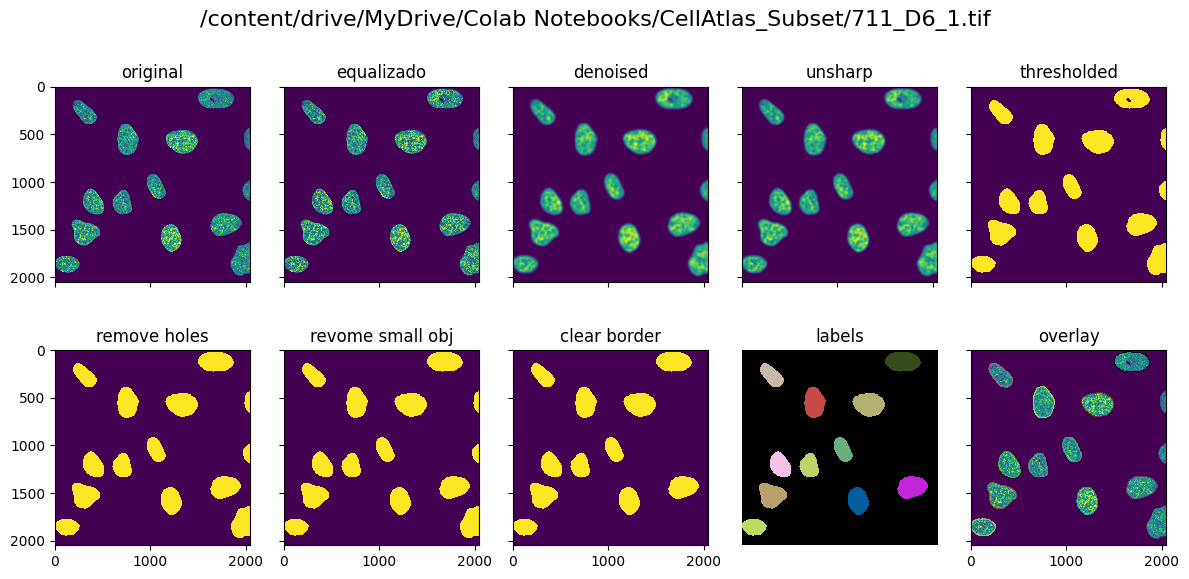

label  area_nucleus  area_convex_nucleus  axis_major_length_nucleus  \
0       1     48.771856            49.270480                  10.558337   
1       2     29.688512            30.049936                   8.684176   
2       3     43.704864            44.126656                   9.177651   
3       4     50.501360            51.022720                   9.399933   
4       5     27.939408            28.250656                   7.928264   
5       6     34.453664            34.739040                   7.989804   
6       7     30.350208            30.666944                   7.129976   
7       8     45.363024            45.838912                   9.024211   
8       9     44.692704            45.976896                   8.418508   
9      10     38.366608            38.671584                   8.154828   
10     11     27.335728            27.659520                   7.099185   

    axis_minor_length_nucleus  eccentricity_nucleus  euler_number_nucleus  \
0                    5.891829              0.829823                     1   
1                    4.408034              0.861597                     1   
2                    6.103315              0.746826                     1   
3                    6.874627              0.682004                     1   
4                    4.512596              0.822214                     1   
5                    5.541357              0.720405                     1   
6                    5.518486              0.633205                     1   
7                    6.451207              0.699250                     1   
8                    7.132361              0.531236                     1   
9                    5.998207              0.677481                     1   
10                   4.921242              0.720733                     1   

                              image_intensity_nucleus  intensity_max_nucleus  \
0   [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...                62511.0   
1   [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...                65535.0   
2   [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...                65535.0   
3   [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...                65535.0   
4   [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...                65535.0   
5   [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...                65535.0   
6   [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...                65535.0   
7   [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...                65535.0   
8   [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...                65535.0   
9   [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...                65535.0   
10  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...                65535.0   

    intensity_mean_nucleus  ...  perimeter_nucleus  solidity_nucleus  \
0             30256.591570  ...          27.737002          0.989880   
1             30604.879106  ...          22.158067          0.987973   
2             34244.228537  ...          25.701786          0.990441   
3             39742.156159  ...          27.344519          0.989782   
4             34356.713668  ...          21.025444          0.988983   
5             35721.609726  ...          22.677786          0.991785   
6             32122.318945  ...          21.155495          0.989672   
7             35513.531774  ...          26.085343          0.989618   
8             35881.473669  ...          26.619333          0.972069   
9             41637.240922  ...          23.652982          0.992114   
10            33207.490693  ...          20.147495          0.988294   

    area_rim                                image_intensity_rim  \
0   8.241408  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
1   7.112448  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
2   7.760816  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
3   8.311968  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
4   6.463296  [[0

In [22]:
%matplotlib inline
#%matplotlib notebook # se usar fora do Colab, pois o colab nao suporta grafico matplot interativos
rodar_analise(arquivo = arquivos[7], k=0, plot=True)

###Executa em todos os arquivos e ger o dtaframe concatenado com todos os dados que foram quantificados

In [11]:
# cria lista vazia para armazenar os dfs individuais
resultados = []

# executa o loop serialmente (lento...) em todos os arquivos listados
for i in tqdm(arquivos):
  print("executando: ", i)
  resultados.append( rodar_analise(i, plot=False) )

# concatena todos os dfs em um unico final, para estatistica
df_final_resultados = pd.concat(resultados, ignore_index=True)

  0%|          | 0/12 [00:00<?, ?it/s]

executando:  /content/drive/MyDrive/Colab Notebooks/CellAtlas_Subset/1894_G3_5.tif
 theshold: 0.23641119842379865
executando:  /content/drive/MyDrive/Colab Notebooks/CellAtlas_Subset/1894_G3_4.tif
 theshold: 0.2646161483017644
executando:  /content/drive/MyDrive/Colab Notebooks/CellAtlas_Subset/711_D6_2.tif
 theshold: 0.23319691898439707
executando:  /content/drive/MyDrive/Colab Notebooks/CellAtlas_Subset/931_H7_2.tif
 theshold: 0.3067676597709327
executando:  /content/drive/MyDrive/Colab Notebooks/CellAtlas_Subset/931_H7_1.tif
 theshold: 0.300603234589772
executando:  /content/drive/MyDrive/Colab Notebooks/CellAtlas_Subset/1773_H11_1.tif
 theshold: 0.1956564513073541
executando:  /content/drive/MyDrive/Colab Notebooks/CellAtlas_Subset/551_C10_1.tif
 theshold: 0.27987679982660396
executando:  /content/drive/MyDrive/Colab Notebooks/CellAtlas_Subset/711_D6_1.tif
 theshold: 0.2579577231687396
executando:  /content/drive/MyDrive/Colab Notebooks/CellAtlas_Subset/783_A5_1.tif
 theshold: 0.26

In [12]:
df_final_resultados

label  area_nucleus  area_convex_nucleus  axis_major_length_nucleus  \
0        1     24.830848            25.046448                   6.438973   
1        2     31.470544            32.010720                   7.355147   
2        3     46.248160            46.895744                  10.256659   
3        4     47.452384            47.942384                  10.908617   
4        5     25.325552            25.664240                   7.258506   
..     ...           ...                  ...                        ...   
117      8     29.085616            29.318464                   8.012350   
118      9     27.469008            27.977040                   6.666415   
119     10     62.950496            65.969680                  11.022319   
120     11     30.978976            32.523456                   6.916160   
121     12     35.075376            35.401520                   9.040118   

     axis_minor_length_nucleus  eccentricity_nucleus  euler_number_nucleus  \
0                     4.922701              0.644604                     1   
1                     5.500770              0.663834                     1   
2                     5.778191              0.826212                     1   
3                     5.550744              0.860861                     1   
4                     4.507056              0.783862                     1   
..                         ...                   ...                   ...   
117                   4.630507              0.816093                     1   
118                   5.320619              0.602495                     1   
119                   7.516294              0.731431                     1   
120                   5.825776              0.538942                     1   
121                   4.968170              0.835448                     1   

                               image_intensity_nucleus  intensity_max_nucleus  \
0    [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...                49613.0   
1    [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...                55197.0   
2    [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...                58588.0   
3    [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...                65535.0   
4    [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...                65535.0   
..                                                 ...                    ...   
117  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...                65535.0   
118  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...                65290.0   
119  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...                65535.0   
120  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...                65535.0   
121  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...                65535.0   

     intensity_mean_nucleus  ...  perimeter_nucleus  solidity_nucleus  \
0              23840.267744  ...          19.046711          0.991392   
1              25896.311004  ...          21.955897          0.983125   
2              29340.745025  ...          27.371695          0.986191   
3              32033.381803  ...          28.061745          0.989779   
4              30803.599356  ...          19.925143          0.986803   
..                      ...  ...                ...               ...   
117            38796.298445  ...          21.242168          0.992058   
118            29116.633901  ...          20.309867          0.981841   
119            42399.836576  ...          32.970046          0.954234   
120            40597.761705  ...          22.495032          0.952512   
121            49826.641163  ...          23.422871          0.990787   

     area_rim                                image_intensity_rim  \
0    5.828256  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
1    6.584032  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
2    8.361360  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
3    8.438976  [[0, 0, 0, 0, 0, 0

###Salva o DF

In [ ]:
df_final_resultados.to_csv("/content/drive/MyDrive/Colab Notebooks/dados_finais.csv")

##exemplos de analises/visualizacoes simples

In [34]:
df_final_resultados["ratio"] = df_final_resultados["intensity_mean_rim"]/df_final_resultados["intensity_mean_nucleus"]

In [35]:
df_final_resultados.plot(kind='violin',y="ratio", color="plate")

In [39]:
df_final_resultados.groupby(["plate", "sample"])["intensity_mean_rim"].describe()

count          mean          std           min           25%  \
plate sample                                                                 
1773  1         5.0   8504.976647  1901.463831   6364.768487   6680.355185   
      2        10.0   8206.432658  1256.884296   6211.427458   7353.694817   
1894  4        10.0  15338.523962  1746.251725  12231.446206  14291.394451   
      5        10.0  14113.416616  1245.263463  12117.996576  13621.270128   
551   1         8.0  18817.219594  1280.682729  17187.226276  18012.872660   
      2        12.0  15553.718585  2897.371637   9976.409273  14211.710789   
711   1        11.0  16064.682904  1631.460094  12173.262191  15962.357707   
      2        12.0  13246.748370  1970.306102   9571.971426  12354.523992   
783   1        12.0  16170.371110  2083.662172  10858.405694  15516.861679   
      2        10.0  16003.908607  1278.098745  13640.265269  16053.686679   
931   1        11.0  18047.395785  1385.626261  15898.483581  17154.049709   
      2        11.0  19408.356402  1684.645758  17281.537872  18200.251777   

                       50%           75%           max  
plate sample                                            
1773  1        9065.358550   9736.369144  10678.031869  
      2        8555.068668   9135.138491   9739.119209  
1894  4       15952.370075  16567.701939  17538.331750  
      5       14292.884209  14479.844380  16131.482139  
551   1       18844.199197  19052.643629  21510.710302  
      2       15671.130052  17738.444869  19500.166164  
711   1       16426.667273  16929.840666  17827.696910  
      2       13825.081677  14795.182907  15521.316357  
783   1       16190.596054  17428.415287  18575.779361  
      2       16265.357625  16950.930193  17154.664956  
931   1       18007.194586  19501.047915  19681.840406  
      2       18947.916365  20900.746522  21964.146775